In [1]:
# !pip install neptune-client
!pip install torch==1.8.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 210 kB 1.3 MB/s 
     |████████████████████████████████| 67 kB 2.9 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.4-py2.py3-none-any.whl size=372176 sha256=f931464e2feb33298f5d4f78446ffe96a36bdc059c572bc7a859a030b126d78f
  Stored in directory: /root/.cache/pip/wheels/d7/e8/5c/7b6dbe19197cf3d99b9e4756d8b93eeeaa7008c348d8f9bb40
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=83e84be83e13c1a0cfa7eab14ceba6932248bd713633478149a953c4a25c4c6a
  Stored in directory: /root/.cache/pip/wheels/f3/1d/9f/2a74caecb81b8beb9a4fbe1754203d4b7cf42ef5d39e0d2311
Successfully built neptune-client strict-rfc3339


In [2]:
import os
import gc
import warnings
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import neptune.new as neptune

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

# NEPTUNE_API_TOKEN = os.environ["NEPTUNE_API_TOKEN"]
import pickle
NEPTUNE_API_TOKEN = pickle.load(open('../input/tokens/neptune_token.pkl', 'rb'))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [3]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter


def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

In [4]:
EPSILON = 1e-38

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

In [5]:
def get_submittion(preds, df_test):
    submittion = df_test[['transaction_id']]
    submittion['price'] = preds
    submittion.to_csv('submittion.csv', index=False)


def get_data():
#     df_2017 = pd.read_csv('data/2017.csv')
#     df_2018 = pd.read_csv('data/2018.csv')
#     df_test = pd.read_csv('data/2019.csv')
    df_2017 = pd.read_csv('../input/enbysis-uk-rental/2017.csv')
    df_2018 = pd.read_csv('../input/enbysis-uk-rental/2018.csv')
    df_test = pd.read_csv('../input/enbysis-uk-rental/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


def preprocess_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes(['object', 'category']).columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    df.drop(TO_DROP, axis=1, inplace=True)
    current_to_drop = ['created_month', 'created_quarter', 'created_hour']
    df.drop(current_to_drop, axis=1, inplace=True)
    
    features_num = df.select_dtypes(include=['float16', 'float32', 'float64', 'int32', 'int64']).columns
    f_all = features_cat+ features_str + features_address +features_num.tolist()
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] # - 2 # transaction_id, created
    
    return features_cat, features_num


def categorical_to_numerical_features(df, df_test, features_cat):
    train_size = df.shape[0]
    data = pd.concat([df, df_test], axis=0)[features_cat]
    data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # cat2num = data[features_cat].cat.categories
    data[features_cat] = data[features_cat].apply(lambda x: x.cat.codes.astype('category'))

    return data.iloc[:train_size], data.iloc[train_size:]    

In [6]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=100_000, replace=False)
df = df_ini.iloc[idx]

(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


In [7]:
class ShelterOutcomeDataset(Dataset):
    def __init__(self, df, emb_cols):
        self.embedding_col_names = emb_cols
        self.X1 = df[emb_cols].copy().values.astype(np.int64) #categorical columns
        self.X2 = df.drop(columns=emb_cols + ['price']).copy().values.astype(np.float32) #numerical columns
        self.y = df.price.values.reshape(-1,1).copy().astype(np.float32)
        print(self.X1.shape, self.X2.shape, self.y.shape)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
    
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('__ device cuda')
        return torch.device('cuda')
    else:
        print('__ device cpu')
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [8]:
class EmbeddingNNModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) \
                                         for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.emb_drop = nn.Dropout(0.3)
        
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 256)
        self.drops = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.lin2 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
#         self.lin3 = nn.Linear(70, 16)
#         self.bn4 = nn.BatchNorm1d(16)
        
        self.lin4 = nn.Linear(64, 1)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)] # embeddings for each feature
        x = torch.cat(x, 1) # concatenate them together
        x = self.emb_drop(x)
        
        # x2 = self.bn1(x_cont)
        x2 = x_cont

        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x)) # input_size -> 200
        x = self.drops(x)
        x = self.bn2(x)
        
        x = F.relu(self.lin2(x)) # 200 -> 70
        x = self.drops(x)
        x = self.bn3(x)
        
#         x = F.relu(self.lin3(x)) # 70 -> 16
#         x = self.drops(x)
#         x = self.bn4(x)
        
        x = self.lin4(x) # 70 -> 1
        return x
    
# the same
def train_eval_model(model, criterion, optimizer=None, dl=None):
    n, loss_sum = 0, 0
    n_mdape, loss_mdape_sum = 0, 0
    
    for x1, x2, y in dl:
        batch = y.shape[0]
        output = model(x1, x2)
#         print(output.shape, y.shape)
        loss = criterion(output, y)
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        n += batch
        loss_sum += batch*(loss.item())
        
        with torch.no_grad():
            loss_mdape = mdape(output.cpu(), y.cpu())
            n_mdape += batch
            loss_mdape_sum += batch*(loss_mdape.item())
        
    return loss_sum/n, loss_mdape_sum/n_mdape

# the same
def get_prediction(data, model, embedded_col_names, flag_plot=False):
    dl = get_dataloader(data, embedded_col_names, params_neptune['batch_size'], 
                        device='cpu', flag_train=False)
    preds = []
    with torch.no_grad():
        for x1, x2, y in dl:
            out = model(x1, x2)
            preds.append(out)
    preds = pd.Series([item.item() for sublist in preds for item in sublist])
    if data.price.notna().all():
        print(mdape(data.price.values, preds))
    if flag_plot:
        fig, axes = plt.subplots(1,2, figsize=(10,5))
        temp = pd.concat([preds, val[['price']].reset_index(drop=True)], axis=1)
        temp.columns = ['pred', 'true']
        temp.plot.scatter(x='true', y='pred', ax=axes[0])
        axes[0].set_title('All data')
        sns.regplot(x='true', y='pred', data=temp[temp.true <= temp.pred.max()], 
                    line_kws={'color':'black', 'label': 'regression'}, ax=axes[1])
        plt.plot([0, temp.pred.max()], [0, temp.pred.max()], color='black',linestyle='dashed', label='exact pred')
        axes[1].legend()
        axes[1].set_title('Data with price < 1e6')
        return preds, fig
    return preds

# the same
def train_loop(model, train_dl, valid_dl, params_neptune, 
                optimizer, flag_neptune=False, flag_val=True):
    criterion = nn.L1Loss()
    val_mdapes = []

    if flag_val: to_end = ' | '
    else: to_end='\n'
    print('\ttrain\t\t\tval')
    print('\tloss\tmdape\t\tloss\tmdape')
    
    if flag_neptune:
        run = neptune.init(project='declot/Enbysis-UK-Rental', 
                            api_token=NEPTUNE_API_TOKEN,
                            source_files=['3_NN_embedding.ipynb', 'requirements.txt'])
        run['parameters'] = params_neptune
        run["sys/tags"].add(['NN embed', 'NN'])
        run['model'] = model

    for i in range(params_neptune['iterations']): 
        model.train()
        t_loss = train_eval_model(model, criterion, optimizer, train_dl)
        print(f'({i:>3}) {t_loss[0]:.2e}\t{t_loss[1]:>.4e}', end=to_end)
        if flag_val:
            model.eval()
            v_loss = train_eval_model(model, criterion, optimizer=None, dl=valid_dl)
            val_mdapes.append(v_loss[1])
            
            print(f'{v_loss[0]:.2e}\t{v_loss[1]:>.4e}')
            if flag_neptune:
                run['loss/train'].log(t_loss[0])
                run['mdape/train'].log(t_loss[1])
                run['loss/val'].log(v_loss[0])
                run['mdape/val'].log(v_loss[1])
                run['val/mdape'] = np.min(val_mdapes)
                run['cv/mdape_iter'] = np.argmin(val_mdapes) + 1

    preds, fig = get_prediction(val, model,valid_dl.dl.dataset.embedding_col_names, True)
    if flag_neptune: 
        run['pred_true'].upload(fig)
        run['val/mdape'] = mdape(val.price.values, preds)
        run.stop()

In [9]:
# + embedded_col_names
def get_dataloader(data, embedded_col_names, batch_size, device, flag_train=True):
    data_ds = ShelterOutcomeDataset(data, embedded_col_names)
    data_dl = DataLoader(data_ds, batch_size=batch_size, shuffle=flag_train)
    data_dl = DeviceDataLoader(data_dl, device)
    return data_dl 

# the same
def model_NN_emb(train, val, model,  embedding_info, params_neptune, 
                 optimizer, flag_neptune=False):
    device = get_default_device()
    train_dl = get_dataloader(train, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
    valid_dl = get_dataloader(val, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
                
    # model = ShelterOutcomeModel(embedding_info['embedding_sizes'], train_dl.dl.dataset.X2.shape[1])
    to_device(model, device)

    train_loop(model, train_dl, valid_dl, params_neptune, 
                optimizer, flag_neptune=flag_neptune)
    return model

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = ['street', 
                    # 'city', 
                'building_number', 'flat',
                'building_name',
                'postcode_sector',
                'postcode']
TO_DROP = ['transaction_id', 'created', 'address_id']

    
class CrossFeatures():
    """cat_cols - list of cat cols to use
       float_cols - list of float cols to use
       relative - change current absolute values to groupby relative
       multi_groups - count of cat_cols to use on each groupby
       func - func to aggregate on groupby
       split_size - count of data splits to cross generate
       rewrite - rewrite float cols values(only if relative)"""
    
    def __init__(self, cat_cols=None, float_cols=None, relative=False, multi_groups=None, func='mean', split_size=2, rewrite=False):
        self.cat_cols = cat_cols
        self.float_cols = float_cols
        self.relative = relative
        self.multi_groups = multi_groups
        self.func = func
        self.split_size = split_size
        self.rewrite = rewrite
        
    
    def fit(self, x):
        x.columns = [str(col) for col in x.columns.tolist()]
        if not self.cat_cols:
            self.cat_cols = x.dtypes[x.dtypes == 'O'].index
        if not self.float_cols:
            self.float_cols = x.dtypes[x.dtypes == float].index.tolist()
        
        if self.multi_groups:
            from itertools import combinations
            self.combinations = combinations(cat_cols, self.multi_groups)
        else:
            self.combinations = self.cat_cols
        
        self.groups = {}
        indices = x.index
        split_len = x.shape[0] // self.split_size
        
#         for i in range(1, self.split_size):
#             self.groups[i] = np.arange(0, split_len * i)
        for i in range(self.split_size - 1):
            self.groups[i] = np.random.choice(indices, size=split_len,replace=False).tolist()
            indices = list(set(indices) - set(self.groups[i]))
        self.groups[self.split_size - 1] = indices
             
        self.grouped_data = {}
        for i in range(self.split_size):
            x_local = x.loc[self.groups[i]]
            self._save_groupby(x_local, str(i))
            
        self._save_groupby(x, 'total')
        return self
        
        
    def _save_groupby(self, x, suffix):
        for comb in self.combinations:
            key = self._check_tuple(comb)
            for float_col in self.float_cols:
                name = self._get_name(key, float_col)
                self.grouped_data[name + suffix] = x.groupby(key)[float_col]
               
            
    def _check_tuple(self, key):
        return list(key) if isinstance(key, tuple) else [key]
    
    
    def _get_name(self, key, float_col):
        return '/'.join(key) + '_' + str(float_col)
    
    
    def _drop_cols(self, x):
        if self.relative and self.rewrite:
            x = x.drop(self.feature_names, axis=1)
        return x


    def _gen_cols(self, x):
        for comb in self.combinations:
            key = self._check_tuple(comb)
            for float_col in self.float_cols:
                name = self._get_name(key, float_col)
                x[name] = np.nan
        return x
    
    
    def transform(self, x, total=True):
        x.columns = [str(col) for col in x.columns]
        if not total:
            x = self._gen_cols(x)

            groups = list(self.groups.keys())
            
            for i in range(self.split_size):
                print(i)
                ind = self.groups[i]
                random_choice = np.random.choice(list(set(groups) - {i}), size=1)[0]
                groups = list(set(groups) - set([random_choice]))
                
                self.feature_names = []
                for comb in self.combinations:
                    key = self._check_tuple(comb)
                    for float_col in self.float_cols:
                        name = self._get_name(key, float_col)
                        join_data = self.grouped_data[name + str(random_choice)].agg(self.func).reset_index()
                        join_data = x.loc[ind].merge(join_data, how='left', on=key)
                        x.loc[ind, name] = join_data[float_col + '_y'].values
                        self.feature_names.append(name)
                            
        else:
            self.feature_names = []
            for comb in self.combinations:
                key = self._check_tuple(comb)
                for float_col in self.float_cols:
                    name = self._get_name(key, float_col)
                    merge_data = self.grouped_data[name + 'total'].agg(self.func).reset_index().rename(columns={float_col: name})
                    self.feature_names.append(name)

                    x = x.merge(merge_data, how='left', on=key)
                    
        if self.relative:
            if self.rewrite:
                x[float_col] /= x[name]
            else:
                x[name] = x[float_col] / x[name]
                        
        x = self._drop_cols(x)
        return x
                        
                    
    def fit_transform(self, x):
        self = self.fit(x)
        return self.transform(x, total=False)
    
    
    def get_feature_names(self):
        return self.feature_names
    
    
    def get_combinations(self):
        return self.combinations


    
def fill_na_by_means_of_group(train, val, test, f_all):
    
    def fill_na_by_given_values(train, means, f_all):
        temp = train[f_all + ['postcode_sector']].merge(means, on='postcode_sector', how='outer')
        f_all_mean = [f+'means' for f in f_all]
        for f, f_mean in tqdm(zip(f_all, f_all_means)):
            print(f, f_mean)
            train[f] = temp.groupby('postcode_sector').apply(lambda x: x[f].fillna(x[f_mean])).droplevel(0).sort_index()
        train[f_all] = train[f_all].fillna(0)
        
    f_all = np.array(f_all)[train[f_all].isna().any()].tolist()
    temp = train[f_all + ['postcode_sector']]
    print(f'# of features to fill with postcode_sector means: {len(f_all)}')
    temp[f_all] = temp[f_all]. astype('float')
    transf = CrossFeatures(['postcode_sector'], f_all, split_size=2                      )
    transf.fit_transform(temp)
    f_all_means = ['postcode_sector' + '_' + f for f in f_all]
    
#     means = temp.groupby('postcode_sector', as_index=False).mean()
#     means.columns = ['postcode_sector']  + f_all_means

    fill_na_by_given_values(train, temp[f_all_means + ['postcode_sector']], f_all)
    fill_na_by_given_values(val, temp[f_all_means + ['postcode_sector']], f_all)
#     fill_na_by_given_values(test, mean, f_all)
 
    
from sklearn.impute import SimpleImputer

def preprocess_total(df, df_test):
    df, df_test = df.copy(), df_test.copy()
    features_cat, features_num = preprocess_main(df)
    _ = preprocess_main(df_test)
    df_test['price'] = np.nan

    # nans in cat
    df[features_cat], df_test[features_cat] = categorical_to_numerical_features(df, df_test,
                                                                           features_cat)

    df[features_cat] = df[features_cat].astype('category')
    embedded_cols = {n: len(col.cat.categories) for n,col in df[features_cat].items() if len(col.cat.categories) > 2}
    embedded_col_names  = list(embedded_cols.keys())
    embedding_sizes = [(c, min(50, (c+1)//2)) for _,c in embedded_cols.items()]
    embedding_info = dict(embedded_col_names=embedded_col_names,
                        embedding_sizes=embedding_sizes)
    print(f'''# features in ohe: {np.sum([x[0] for x in embedding_sizes])}
# features in embedding: {np.sum([x[1] for x in embedding_sizes])}''')

    
    cv_folds = TimeSeriesSplit(n_splits=5)
    cv_idx = list(cv_folds.split(df, df.price))[-1]
    train = df.iloc[cv_idx[0]]
    val = df.iloc[cv_idx[1]]

    f_all = train.drop(embedded_col_names + ['price'], axis=1)\
            .select_dtypes(exclude=['object', 'string']).columns.tolist()
    # # display(train[f_all].dtypes)
    ss = StandardScaler().fit(train[f_all])
    train[f_all] = ss.transform(train[f_all])
    val[f_all] = ss.transform(val[f_all])
    df_test[f_all] = ss.transform(df_test[f_all])
    
#     fill_na_by_means_of_group(train, val, df_test, f_all)
#     df[features_num] = df[features_num].fillna(0)
    imp = SimpleImputer()
    train[f_all] = imp.fit_transform(train[f_all])
    val[f_all] = imp.transform(val[f_all])

    return train, val, df_test, features_cat, embedding_info


train, val, test, features_cat, emb_info = preprocess_total(df, df_test)
features = features_str + features_address #+ ['price']
train.drop(features, axis=1, inplace=True)
val.drop(features, axis=1, inplace=True)
test.drop(features, axis=1, inplace=True)

assert (train.isna().sum() == 0).all()

train.to_csv('train.csv')
val.to_csv('val.csv')
test.to_csv('test.csv')

embedding_col_names = emb_info['embedded_col_names']


In [12]:
train.price.describe(), train.price.quantile(0.99)/1e5

(count    8.333400e+04
 mean     3.489023e+05
 std      2.688850e+06
 min      1.000000e+00
 25%      1.440000e+05
 50%      2.280000e+05
 75%      3.505000e+05
 max      5.943000e+08
 Name: price, dtype: float64,
 18.0)

In [13]:
train.isna().sum()

duration                          0
price                             0
old_new                           0
ppd_category                      0
property_type                     0
floor_level                       0
number_of_rooms                   0
total_floor_area                  0
epc_current_energy_rating         0
epc_potential_energy_rating       0
epc_property_type                 0
epc_built_form                    0
epc_energy_consumption_current    0
epc_lighting_cost_current         0
epc_heating_cost_current          0
epc_hot_water_cost_current        0
epc_flat_storey_count             0
epc_glazed_area                   0
epc_number_open_fireplaces        0
epc_windows_energy_eff            0
epc_walls_energy_eff              0
epc_roof_energy_eff               0
epc_floor_height                  0
city                              0
latitude                          0
longitude                         0
closeststop                       0
crimesin3km_antisocial      

In [14]:
# train_filled = train.copy()
# val_filled = val.copy()

24
__ device cpu
(83334, 11) (83334, 24) (83334, 1)
(16666, 11) (16666, 24) (16666, 1)
	train			val
	loss	mdape		loss	mdape
https://ui.neptune.ai/declot/Enbysis-UK-Rental/e/EN-84
(  0) 3.48e+05	1.1722e+04 | 3.42e+05	1.3130e+02
(  1) 3.45e+05	6.8922e+01 | 3.37e+05	3.2580e+01
(  2) 3.39e+05	2.2106e+01 | 3.29e+05	1.4151e+01
(  3) 3.29e+05	1.0783e+01 | 3.19e+05	8.0041e+00
(  4) 3.18e+05	6.1919e+00 | 3.05e+05	4.7322e+00
(  5) 3.03e+05	3.9204e+00 | 2.90e+05	3.0330e+00
(  6) 2.87e+05	2.6144e+00 | 2.72e+05	2.0618e+00
(  7) 2.69e+05	1.8023e+00 | 2.54e+05	1.4673e+00
(  8) 2.50e+05	1.2730e+00 | 2.37e+05	1.1116e+00
(  9) 2.30e+05	9.1505e-01 | 2.12e+05	7.1199e-01
( 10) 2.10e+05	6.5317e-01 | 1.94e+05	5.3017e-01
( 11) 1.91e+05	4.6698e-01 | 1.80e+05	4.2342e-01
( 12) 1.75e+05	3.4532e-01 | 1.60e+05	2.7365e-01
( 13) 1.63e+05	2.7559e-01 | 1.52e+05	2.4044e-01
( 14) 1.55e+05	2.3890e-01 | 1.44e+05	2.0854e-01
( 15) 1.50e+05	2.2148e-01 | 1.41e+05	2.0026e-01
( 16) 1.47e+05	2.1376e-01 | 1.38e+05	1.9405e-01
( 17)

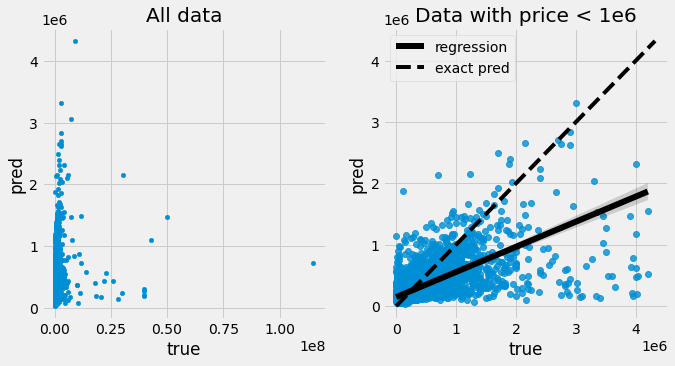

In [15]:
%%time
input_size = train.shape[1] - len(emb_info['embedded_col_names']) - 1 # price
print(input_size)

params_neptune = dict(loss_function = 'MAE',
                      iterations = 50,
                      batch_size = 264,
                      learning_rate = 0.01, #0.05,
                      l2_reg=0.0001,
                      n_features = input_size + np.sum([x[1] for x in emb_info['embedding_sizes']])
             )

model = EmbeddingNNModel(emb_info['embedding_sizes'], input_size)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), 
                       lr=params_neptune['learning_rate'],
                        #    weight_decay=params_neptune['l2_reg'])
    )

m = model_NN_emb(train, val,model, emb_info, params_neptune, optimizer, 
                 flag_neptune=True)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e0716c79-cd49-421b-b62e-acc802240d39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>